# Out of Africa model

In [2]:
import moments
import demes
import demesdraw
import matplotlib.pyplot as plt
import pickle

from IPython.display import Markdown as md
import warnings

# Function for printing syntax-highlighted YAML demes models
# If there is a better way to do this, tell me!!
def print_model(file_path):
    with open(file_path) as f:
        lines = f.read()
    return md("```yaml\n" + lines + "```")
warnings.filterwarnings('ignore')

## Parametrized model

We are working with the out of Africa model.

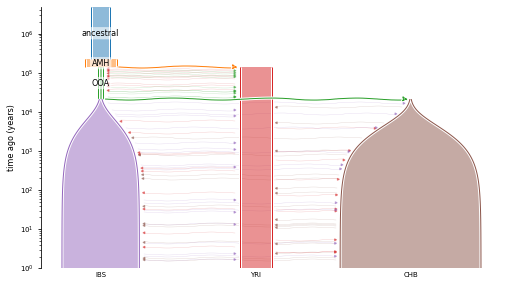

In [5]:
# this file contains the parametrization of the model
ooa_yml = "./gutenkunst_2009.yaml"
ooa = demes.load("./gutenkunst_2009.yaml")
demesdraw.tubes(ooa, log_time=True)
plt.show();

In [6]:
print_model(ooa_yml)

```yaml
# I modified to have IBS instead of CEU
description: The Gutenkunst et al. (2009) three-population model of human history. Time
  is given in years in the past. Choices to make, 1) which ends of the epochs should
  start and end times describe, 2) once that's decided, initial and final sizes should
  correspond to start and end time, resp. Currently, I'm looking backward in time, so
  start time is more recent and end time is the epoch interval end point farther in the
  past.
doi:
  - https://doi.org/10.1371/journal.pgen.1000695
time_units: years
generation_time: 25
demes:
  - name: ancestral
    description: Equilibrium/root population
    epochs:
    - end_time: 220e3
      start_size: 7300
  - name: AMH
    description: Anatomically modern humans
    ancestors: [ancestral]
    epochs:
    - end_time: 140e3
      start_size: 12300
  - name: OOA
    description: Bottleneck out-of-Africa population
    ancestors: [AMH]
    epochs:
    - end_time: 21.2e3
      start_size: 2100
  - name: YRI
    description: Yoruba in Ibadan, Nigeria
    ancestors: [AMH]
    epochs:
    - start_size: 12300
      end_time: 0
  - name: IBS
    description: Iberian populations in Spain (IBS).
    ancestors: [OOA]
    epochs:
    - start_size: 1000
      end_size: 29725
      end_time: 0
  - name: CHB
    description: Han Chinese in Beijing, China
    ancestors: [OOA]
    epochs:
    - start_size: 510
      end_size: 54090
      end_time: 0
migrations:
  - demes: [YRI, OOA]
    rate: 25e-5
  - demes: [YRI, IBS]
    rate: 3e-5
  - demes: [YRI, CHB]
    rate: 1.9e-5
  - demes: [IBS, CHB]
    rate: 9.6e-5
```

# SFS inference

## Which paramaters do we want to infer?

I am following the [moments example](https://moments.readthedocs.io/en/latest/extensions/demes.html). I will infer the follwing parameters: TA, TB, and TF.

In [7]:
options = "./ooa_options.yaml"
print_model(options)

```yaml
parameters:
- name: N_B
  description: Bottleneck size for Eurasian populations
  values:
  - demes:
      OOA:
        epochs:
          0: start_size
- name: m_Af_Eu
  description: Symmetric migration rate between Afr and Eur populations
  upper_bound: 1e-3
  values:
  - migrations:
      1: rate
- name: TA
  description: Time before present of ancestral expansion
  values:
  - demes:
      ancestral:
        epochs:
          0: end_time
- name: TB
  description: Time of YRI-OOA split
  values:
  - demes:
      AMH:
        epochs:
          0: end_time
- name: TF
  description: Time of IBS-CHB split
  values:
  - demes:
      OOA:
        epochs:
          0: end_time
constraints:
- params: [TA, TB]
  constraint: greater_than
- params: [TB, TF]
  constraint: greater_than
```

## The data

I [computed](compute-sfs.py) the joint SFS (all autosomes) for synonymous variants. I will project this SFS to a smaller sample size to make the optimization run faster.



In [8]:
filehandler = open("data/spectrum.pkl", "rb")
data = pickle.load(filehandler)
filehandler.close()
print(data.pop_ids)

['CHB', 'IBS', 'YRI']


In [10]:
n = 20
data = data.project([n, n, n])

## Optimization

Since we are using synonymous variants I will use the same scaled mutation rate as in the moments example.

In [11]:
uL = 0.14419746897690008
output = "./results/ooa_best_fit_model.yml"
ret = moments.Demes.Inference.optimize(
    deme_graph=ooa_yml,
    output=output,
    inference_options=options,
    data=data,
    verbose=100,
    uL=uL,
    overwrite=True
)

100     , -10620      , array([ 4290.76    ,  1.6717e-05 ,  3.47287e+06,  636936     ,  33946.6    ])
200     , -10483.6    , array([ 3653.07    ,  2.9503e-05 ,  1.27706e+07,  6.27698e+06,  38806.9    ])
300     , -10483.5    , array([ 3648.19    ,  2.94617e-05,  1.60161e+07,  9.01723e+06,  38696.3    ])
400     , -10483.5    , array([ 3648.23    ,  2.94615e-05,  1.9987e+07 ,  1.34554e+07,  38695.5    ])
500     , -10483.5    , array([ 3648.23    ,  2.94615e-05,  2.13973e+07,  1.52177e+07,  38695.6    ])


## Results

In [12]:
param_names, opt_params, LL = ret
print("Log-likelihood:", -LL)
print("Best fit parameters")
for n, p in zip(param_names, opt_params):
    print(f"{n}\t{p:.3}")

Log-likelihood: -10483.536696463243
Best fit parameters
N_B	3.65e+03
m_Af_Eu	2.95e-05
TA	2.14e+07
TB	1.52e+07
TF	3.87e+04


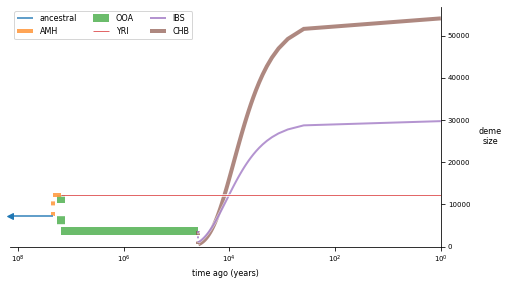

In [13]:
opt_model = demes.load(output)
demesdraw.size_history(opt_model, invert_x=True, log_time=True);

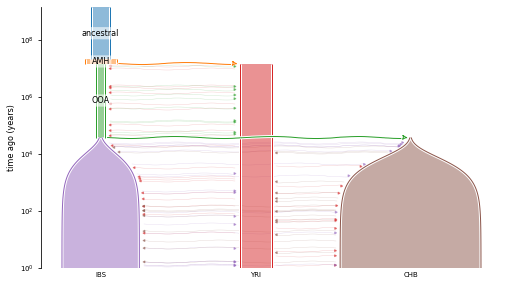

In [21]:
demesdraw.tubes(opt_model, log_time=True);

## Comparing SFS: model vs data

In [14]:
fs = moments.Spectrum.from_demes(output, data.pop_ids, data.sample_sizes)

['CHB']


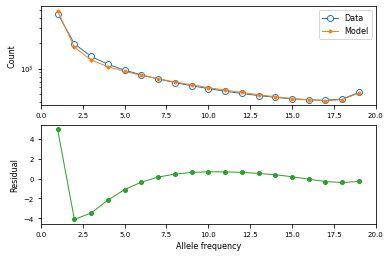

In [15]:
yr_mdl = fs.marginalize([1, 2])
yr_data = data.marginalize([1, 2])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['YRI']


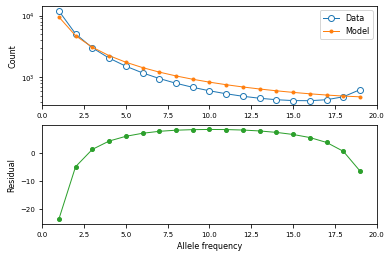

In [19]:
yr_mdl = fs.marginalize([0, 1])
yr_data = data.marginalize([0, 1])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['IBS']


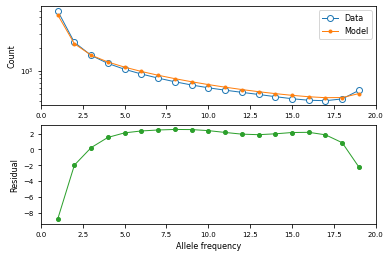

In [16]:
yr_mdl = fs.marginalize([0, 2])
yr_data = data.marginalize([0, 2])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['CHB', 'YRI']


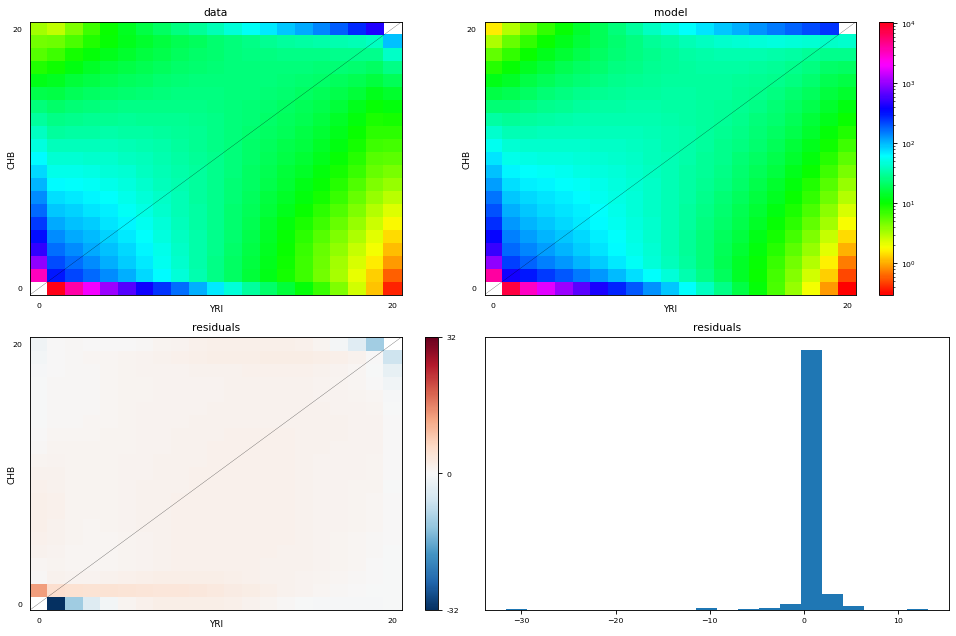

In [20]:
yr_mdl = fs.marginalize([1])
yr_data = data.marginalize([1])
print(yr_data.pop_ids)
plt.figure(figsize=(12, 8), dpi=80)
moments.Plotting.plot_2d_comp_multinom(yr_mdl, yr_data);

['CHB', 'IBS']


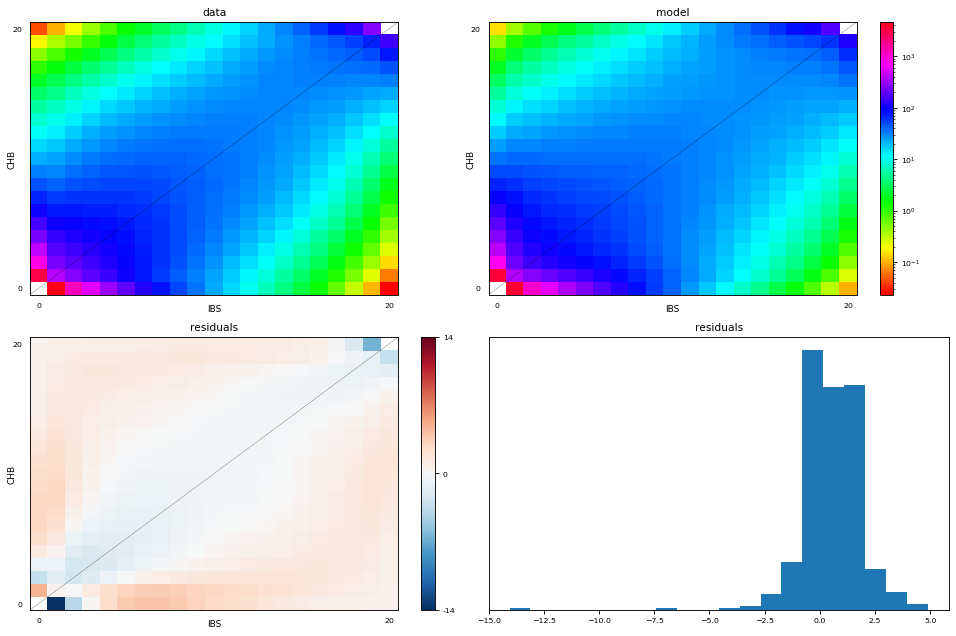

In [18]:
yr_mdl = fs.marginalize([2])
yr_data = data.marginalize([2])
print(yr_data.pop_ids)
plt.figure(figsize=(12, 8), dpi=80)
moments.Plotting.plot_2d_comp_multinom(yr_mdl, yr_data);